### **Lab 07 - Email EDA (Clustering)**

**Paige Rosynek, 01.31.2023**

#### **Introduction**

In this lab, we will continue to explore the email data containing 63,542 emails classified as 'spam' or 'ham'. In this lab we will again be performing dimensionality reduction on the body of each of the emails to create a projected feature matrix with 10 features. Using what we know about the data from lab 06, we will perform clustering on the projected feature matrix to find two distinct clusters using DBSCAN. Lastly, we will perform statistical analysis on the clusters to gain insight into our data.

**Import Libraries**

In [1]:
import pandas as pd
import pathlib
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csc_array
from scipy import stats

#### **Load & Transform the Data**

In [2]:
def extract_json(file):
    with open(file, "r") as read_file:
        obj = json.load(read_file)
    return obj

In [3]:
directory = pathlib.Path('../data/email_json/email_json/')
file_list = list(directory.iterdir())
data = list(map(lambda file : extract_json(file), file_list))
df = pd.DataFrame.from_records(data)

In [4]:
df.head()

,category,to_address,from_address,subject,body
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che..."
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t..."
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      63542 non-null  object
 1   to_address    63141 non-null  object
 2   from_address  63542 non-null  object
 3   subject       63410 non-null  object
 4   body          63542 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


#### **Extract Features**

In [6]:
vectorizer = CountVectorizer(binary=True, min_df=10)
word_matrix = vectorizer.fit_transform(df['body'].tolist())

In [7]:
word_matrix.shape

(63542, 32144)

##### **Dimensionality Reduction**

In [8]:
tsvd = TruncatedSVD(n_components=10)
projected_matrix = tsvd.fit_transform(word_matrix)

In [9]:
projected_matrix.shape

(63542, 10)

#### **Cluster the Emails - DBSCAN**

**DBSCAN**

The clustering algorithm I chose to use on the projected feature matrix is DBSCAN. Since the projected matrix has > 63k samples, I knew that Hierarchical clustering would not be a good choice because it does not scale well to the number of samples. Based on the plots of the projected data in lab 6, I knew that the shape of the clusters formed by the projected feature matrix was not globular and somewhat dense, so K-Means would also not be a good choice. Therefore, I decided to use DBSCAN for this data. DBSCAN is a density-based algorithm that can identify clusters that are irregularly shaped and can also determine any outliers or noise in our data. For the hyperparameters, I arbitrarily chose an epsilon value of 0.8 and minimum number of samples of 10 since the data is fairly dense.

In [10]:
dbscan = DBSCAN(eps=0.8, min_samples=10)
model = dbscan.fit(projected_matrix[:, :2])

Add the clustered data to the dataframe. Note that samples labeled as noise have the cluster value of -1.

In [11]:
df['cluster'] = model.labels_
df.head()

,category,to_address,from_address,subject,body,cluster
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,0
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...,0
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",0
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha...",0


**Plot the Clustered Data**

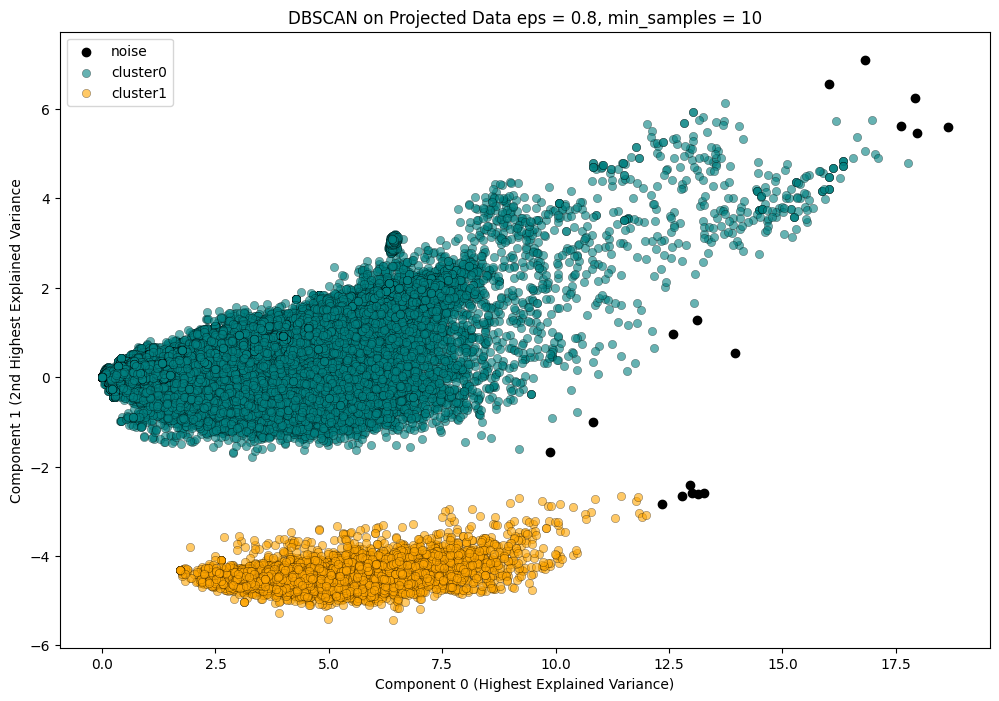

In [12]:
noise_mask = np.where(df['cluster'] == -1)
cluster0_mask = np.where(df['cluster'] == 0)
cluster1_mask = np.where(df['cluster'] == 1)
plt.figure(figsize=(12,8))
plt.scatter(projected_matrix[noise_mask, 0], projected_matrix[noise_mask, 1], c='black', label='noise')
plt.scatter(projected_matrix[cluster0_mask, 0], projected_matrix[cluster0_mask, 1], c='teal', alpha=0.6, edgecolors='black', linewidths=0.3, label='cluster0')
plt.scatter(projected_matrix[cluster1_mask, 0], projected_matrix[cluster1_mask, 1], c='orange', alpha=0.6, edgecolors='black', linewidths=0.3, label='cluster1')
plt.xlabel('Component 0 (Highest Explained Variance)')
plt.ylabel('Component 1 (2nd Highest Explained Variance')
plt.title('DBSCAN on Projected Data eps = 0.8, min_samples = 10')
plt.legend()

We can observe from the plot above, DBSCAN was able to determine two distinct clusters with only a few noise points.

#### **Calculating Document Frequencies of Words**

Create a separate matrix containing samples from the feature matrix that are assigned to a given cluster for each cluster.

In [13]:
cluster0 = word_matrix[cluster0_mask]
cluster1 = word_matrix[cluster1_mask]

**Convert the cluster matricies to CSC format**

In [14]:
cluster0_csc = csc_array(cluster0)
cluster1_csc = csc_array(cluster1)

In [15]:
cluster0_csc.shape

(57738, 32144)

In [16]:
cluster1_csc.shape

(5787, 32144)

We can observe from the output above, that cluster 0 contains significantly more data samples that cluster 1. Cluster 0 contains 57738 samples and cluster 1 contains 5787 samples.

**Calculate the document frequency for each word in each cluster**

The document frequency is the number of documents that contain each word. Since the feature matrix is binary, we can simply sum along the columns.

In [17]:
cluster0_doc_freq = cluster0_csc.sum(axis=0)
cluster1_doc_freq = cluster1_csc.sum(axis=0)

In [18]:
cluster0_doc_freq.shape

(32144,)

In [19]:
cluster1_doc_freq.shape

(32144,)

After calculating the document frequency of each of the CSC the shape of both frequency matricies are (32144,) which makes sense because there are 32144 words in the vocabulary. This can be interpreted such that each row represents a word in the vocabulary.

**Find the document frequencies of the words "love", "works", and "different" for the emails in each cluster**

In [20]:
works_col_index = vectorizer.vocabulary_['works']
love_col_index = vectorizer.vocabulary_['love']
diff_col_index = vectorizer.vocabulary_['different']
print(f'"works" column index = {works_col_index}')
print(f'"love" column index = {love_col_index}')
print(f'"different" column index = {diff_col_index}')

"works" column index = 31687
"love" column index = 18037
"different" column index = 10151


**"works"**

In [21]:
works_doc_freq0 = cluster0_doc_freq[works_col_index]
works_doc_freq1 = cluster1_doc_freq[works_col_index]
print(f'cluster 0 document frequency of "works" : {works_doc_freq0}')
print(f'cluster 1 document frequency of "works" : {works_doc_freq1}')

cluster 0 document frequency of "works" : 2372
cluster 1 document frequency of "works" : 630


**"love"**

In [22]:
love_doc_freq0 = cluster0_doc_freq[love_col_index]
love_doc_freq1 = cluster1_doc_freq[love_col_index]
print(f'cluster 0 document frequency of "love" : {love_doc_freq0}')
print(f'cluster 1 document frequency of "love" : {love_doc_freq1}')

cluster 0 document frequency of "love" : 2016
cluster 1 document frequency of "love" : 23


**"different"**

In [23]:
diff_doc_freq0 = cluster0_doc_freq[diff_col_index]
diff_doc_freq1 = cluster1_doc_freq[diff_col_index]
print(f'cluster 0 document frequency of "works" : {diff_doc_freq0}')
print(f'cluster 1 document frequency of "works" : {diff_doc_freq1}')

cluster 0 document frequency of "works" : 2093
cluster 1 document frequency of "works" : 786


#### **Find Enriched Words with Statistical Testing**

We are going to use a Binomial test to determine if the number of occurrences of a given word in a given cluster is higher than what would be expected from the other cluster.

- *Null hypothesis* : The relative document frequencies of the observed cluster are less or equal to those of the tested.
- *Alternative hypothesis* : The alternative hypothesis is that the document frequency is higher in cluster 0 than cluster 1.

**Test if the words "works" and "love" are enriched in cluster 0**

**"works"**

In [24]:
cluster_1_expected_prob = works_doc_freq1 / cluster1.shape[0]
cluster_0_expected_prob = works_doc_freq0 / cluster0.shape[0]
p_value = stats.binom_test(works_doc_freq0, cluster0.shape[0], cluster_1_expected_prob, alternative="greater")
print(f'"works" cluster 1 expected probability = {cluster_1_expected_prob}')
print(f'"works" cluster 0 expected probability = {cluster_0_expected_prob}')
print(f'p_value = {p_value}')

"works" cluster 1 expected probability = 0.1088646967340591
"works" cluster 0 expected probability = 0.041082129620007624
p_value = 1.0


The binomial test for "works" resulted in a p-value of 1.0 which indicates that the observed frequency of "works" for cluster 0 is **not** greater than the frequency of the word for cluster 1.

**"love"**

In [25]:
cluster_1_expected_prob = love_doc_freq1 / cluster1.shape[0]
cluster_0_expected_prob = love_doc_freq0 / cluster0.shape[0]
p_value = stats.binom_test(love_doc_freq0, cluster0.shape[0], cluster_1_expected_prob, alternative="greater")
print(f'"love" cluster 1 expected probability = {cluster_1_expected_prob}')
print(f'"love" cluster 0 expected probability = {cluster_0_expected_prob}')
print(f'p_value = {p_value}')

"love" cluster 1 expected probability = 0.003974425436322792
"love" cluster 0 expected probability = 0.034916346253767015
p_value = 0.0


The binomial test for "love" resulted in a p-value of 0.0 which indicates that the observed frequency of "love" for cluster 0 is **greater** than the frequency of the word for cluster 1.

##### **Find all enriched words for cluster 0 using threshold of 0.05**

In [26]:
enriched_words0 = []

for word, index in vectorizer.vocabulary_.items():
    cluster_1_expected_prob = cluster1_doc_freq[index] / cluster1.shape[0]
    p_value = stats.binom_test(cluster0_doc_freq[index], cluster0.shape[0], cluster_1_expected_prob, alternative="greater")
    
    if (p_value < 0.05):
        enriched_words0.append((p_value, word, cluster0_doc_freq[index]))

c:\Python310\lib\site-packages\scipy\stats\_discrete_distns.py:86: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)


**Filter any words that contain non-alphabetic characters**

In [27]:
enriched_words0 = list(filter(lambda item: item[1].isalpha(), enriched_words0))

In [28]:
len(enriched_words0)

20300

**Sort the words in ascending order by p-value**

In [29]:
sorted_enriched_words0 = sorted(enriched_words0, key=lambda item: item[0], reverse=False)

**First 200 enriched words for cluster 0**

In [30]:
sorted_enriched_words0[:200]

[(0.0, 'feel', 2141),
 (0.0, 'pressure', 767),
 (0.0, 'viagra', 4675),
 (0.0, 'your', 25841),
 (0.0, 'gulus', 11),
 (0.0, 'ca', 5234),
 (0.0, 'lenny', 43),
 (0.0, 'logiciel', 12),
 (0.0, 'unsubscribe', 7384),
 (0.0, 'request', 2532),
 (0.0, 'contact', 5238),
 (0.0, 'listmaster', 970),
 (0.0, 'authentic', 181),
 (0.0, 'mega', 467),
 (0.0, 'authenticv', 74),
 (0.0, 'discount', 1109),
 (0.0, 'pricec', 74),
 (0.0, 'pricedo', 74),
 (0.0, 'miss', 1407),
 (0.0, 'click', 7705),
 (0.0, 'here', 13616),
 (0.0, 'billy', 104),
 (0.0, 'night', 2138),
 (0.0, 'we', 17280),
 (0.0, 'said', 5584),
 (0.0, 'felt', 637),
 (0.0, 'insecure', 191),
 (0.0, 'manhood', 23),
 (0.0, 'toilets', 63),
 (0.0, 'secret', 545),
 (0.0, 'weapon', 88),
 (0.0, 'girls', 419),
 (0.0, 'love', 2016),
 (0.0, 'pills', 2779),
 (0.0, 'every', 4413),
 (0.0, 'ctmay', 38),
 (0.0, 'ring', 428),
 (0.0, 'home', 4086),
 (0.0, 'respect', 1412),
 (0.0, 'technology', 1542),
 (0.0, 'society', 528),
 (0.0, 'agencies', 145),
 (0.0, 'cashing', 16)

##### **Find all enriched words for cluster 1 using threshold of 0.05**

In [31]:
enriched_words1 = []

for word, index in vectorizer.vocabulary_.items():
    cluster_0_expected_prob = cluster0_doc_freq[index] / cluster0.shape[0]
    p_value = stats.binom_test(cluster1_doc_freq[index], cluster1.shape[0], cluster_0_expected_prob, alternative="greater")
    
    if (p_value < 0.05):
        enriched_words1.append((p_value, word, cluster1_doc_freq[index]))

**Filter any words that contain non-alphabetic characters**

In [32]:
enriched_words1 = list(filter(lambda item: item[1].isalpha(), enriched_words1))

In [33]:
len(enriched_words1)

4524

**Sort the words in ascending order by p-value**

In [34]:
sorted_enriched_words1 = sorted(enriched_words1, key=lambda item: item[0], reverse=False)

**First 200 enriched words for cluster 1**

In [35]:
sorted_enriched_words1[:200]

[(0.0, 'do', 5787),
 (0.0, 'the', 5787),
 (0.0, 'to', 5392),
 (0.0, 'and', 5775),
 (0.0, 'of', 4749),
 (0.0, 'self', 5787),
 (0.0, 'hi', 1905),
 (0.0, 'there', 2502),
 (0.0, 'is', 4737),
 (0.0, 'in', 4847),
 (0.0, 'example', 1329),
 (0.0, 'http', 5787),
 (0.0, 'org', 5787),
 (0.0, 'this', 4097),
 (0.0, 'packages', 593),
 (0.0, 'which', 2069),
 (0.0, 'html', 5720),
 (0.0, 'that', 3726),
 (0.0, 'but', 3406),
 (0.0, 'my', 2186),
 (0.0, 'package', 1373),
 (0.0, 'am', 2219),
 (0.0, 'can', 3017),
 (0.0, 'how', 2172),
 (0.0, 'would', 2145),
 (0.0, 'model', 646),
 (0.0, 'factor', 440),
 (0.0, 'guide', 5787),
 (0.0, 'any', 2087),
 (0.0, 'use', 2196),
 (0.0, 'function', 2059),
 (0.0, 'following', 1281),
 (0.0, 'help', 5787),
 (0.0, 'please', 5716),
 (0.0, 'message', 1641),
 (0.0, 'www', 5787),
 (0.0, 'nabble', 398),
 (0.0, 'mailing', 5787),
 (0.0, 'list', 5730),
 (0.0, 'archive', 481),
 (0.0, 'stat', 5787),
 (0.0, 'math', 5787),
 (0.0, 'ethz', 5787),
 (0.0, 'ch', 5787),
 (0.0, 'https', 5702),
 (

#### **Reflection Questions**

***a. Make a guess as to why the emails might form two distinct clusters.***

The emails may form two distinct clusters because certain words are used more often in spam messages than ham messages, causing them to form clusters. A lot of spam is phising emails which often try to get users to enter their personal information into a fake site, however these types of emails often have a similar structure and contain similar phases which may explain why spam data tends to be clustered away from ham data.

***b. Are spam messages in both clusters or a single cluster?***

Spam messages are only in cluster 0, however ham messages are in both cluster 1 and cluster 0.

***c. Skim through the top 200 words for each cluster. Can you identify any patterns for either of the clusters?***

After examining the first 200 words for cluster 1 (ham), I noticed that the most frequent words are common stop words like 'do', 'the', 'to', and 'and' to new a few. I observed from the first 200 words for cluster 0 (spam and ham) that the most frequent words are mispelled and quite random with words like: 'viagra', 'pressure', and 'your'. These words are most likely to occur in spam messages.


***d. Select the rows in the DataFrames for the emails in cluster 0. Print the top 25. Do the same for cluster 1. Do you the to and from addresses and subject lines provide additional help in identifying patterns?***

In [36]:
df[df['cluster'] == 0].head(25)

,category,to_address,from_address,subject,body,cluster
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,0
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...,0
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",0
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha...",0
5,spam,manager@speedy.uwaterloo.ca,"""Bobby L. Fleming"" <zvyrepeated@liselebel.com>",Which is duty,\n\n\n\n\n\n\nthe program and the creative abi...,0
6,spam,"""Theorize"" <theorize@plg.uwaterloo.ca>","""Esteban Everett"" <dbmagyrln@dbmag.com>",Theorize get inside for local esc0rts who do i...,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,0
7,spam,theorize@plg.uwaterloo.ca,Real Loss <fibond@terra.com.do>,Losing Weight Quickly,\n\n\n\n\n\n HoodiaLife - Start Losing Weight ...,0
9,spam,<smile@speedy.uwaterloo.ca>,"""Billy Chin"" <boxer@0733.com>",For Smile,\n\n\n\n\n\n\nGood day!\nVisit our new online ...,0
10,spam,ftp@plg.uwaterloo.ca,"""Josie Abernathy"" <cebcalhounrennerhog@calhoun...",Less weight - more pleasure and joy,\nCheck out the wonders of pound melting\n\n\n...,0


We can observe from the spam data samples that belong to cluster 0, that the 'from_address' value is almost always the name of a real person or company with odd url endings, whereas the 'to_address' values are different emails with the same address location, which indicates that a hacker was targeting a certain company. This information may be helpful in identifying spam emails. The 'subject' values often contain similar words and phrases that often try to entice users into clicking on the email.

In [37]:
df[df['cluster'] == 1].head(25)

,category,to_address,from_address,subject,body,cluster
8,ham,r-help@stat.math.ethz.ch,"""Jochen.F"" <jjfahr@ucalgary.ca>",[R] Confidence-Intervals.... help...,\nHi...\n\nI have to use R to find out the 90%...,1
16,ham,"""Jochen.F"" <jjfahr@ucalgary.ca>","""Sarah Goslee"" <sarah.goslee@gmail.com>",Re: [R] Confidence-Intervals.... help...,Hm... sounds like a homework problem to me...\...,1
24,ham,r-help@stat.math.ethz.ch,Michael Kubovy <kubovy@virginia.edu>,[R] Failure of mcsamp() but not mcmcsamp(),"Daer r-helpers,\n\nCan anyone help with the fo...",1
68,ham,"""Wilfred Zegwaard"" <wilfred.zegwaard@gmail.com>","""Johann Hibschman"" <johannh@gmail.com>",Re: [R] Reasons to Use R,"On 4/6/07, Wilfred Zegwaard wrote:\n\n> I'm n...",1
75,ham,"""Johann Hibschman"" <johannh@gmail.com>","""Gabor Grothendieck"" <ggrothendieck@gmail.com>",Re: [R] Reasons to Use R,"On 4/8/07, Johann Hibschman wrote:\n> R's pas...",1
112,ham,r-help@stat.math.ethz.ch,"""Zia Uddin Ahmed"" <zua3@cornell.edu>",[R] How do I back transforme ordinary log-krig...,I have a question to everybody.\n\nAfter log10...,1
149,ham,<r-help@stat.math.ethz.ch>,"""Cressoni, Massimo \(NIH/NHLBI\) [F]"" <cresson...",[R] Plot symbols dimensions,\nI am writing some code to obtain publication...,1
278,ham,r-help@stat.math.ethz.ch,Wilfred Zegwaard <wilfred.zegwaard@gmail.com>,Re: [R] Reasons to Use R,"Dear Johann and Gabor,\n\nIt's what amounts to...",1
307,ham,r-help@stat.math.ethz.ch,=?ISO-2022-JP?B?GyRCQG44fRsoQiAbJEI9JDwjGyhC?=...,[R] Could not fit correct values in discrimina...,"Dear R-users,\n\nI would like to use ""bruto"" f...",1
318,ham,r-help@stat.math.ethz.ch,"""joey repice"" <fireseedmusic@gmail.com>",[R] R:Maximum likelihood estimation using BHHH...,"Dear R users,\n\nI am new to R. I would like t...",1


We can observe from the ham data samples that belong to cluster 1, that the 'from_address' value and the 'to_address' values are almost always a real person's name which may be a good indication of a ham email. The subject also often includes 'Re:' which indicates that it is an email chain or conversation indicating that it is a ham email because people often only respond to emails more than once if they trust who they are emailing.

***e. The clusters represent email from two separate mailing lists. One mailing list is for the R programming language, while the other mailing list is for a university. Which mailing list contained all of the spam?***

Cluster 0 contained all of the spam data samples and from further inspection of the 'to_address' we can conclude that all th spam came from the university mailing list. Almost all of the spam emails where to email addresses containing '@plg.uwaterloo.ca'. After some research, I found that University of Waterloo is located in Ontario, Canada which is most likely the university this mailing list was from. It makes sense for universities to get a lot of spam emails because hackers want to obtain the personal information of the students or faculty like their social security number. It also doesn't seem very likely that anyone would want to send spam email to the mailing list for the R language because there is not much to gain from a company like that.

#### **Conclusion**

In this lab, we used DBSCAN to determine two distinct, non-globular clusters in the email data. Cluster 0 contained all of the spam messages, while ham messages were found in both clusters. From our analysis, we were able to find what words occurred most frequently in ham and spam emails. All of the spam emails (in cluster 0) came from the university mailing list and contained more random words most frequently. The most frequent words in cluster 1 were common stop words and a lot of computer science words which makes sense because some of the data came from the R language mailing list. From this process, we were able to conclude that certain words occur more often in spam emails than ham emails.